In [1]:
import requests
import urllib
import json
from urllib.parse import urlencode
import pandas as pd

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/4qY27tJ23G_B1g'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('ab_users_data.csv', 'wb') as f:
    f.write(download_response.content)
ab_users_data = pd.read_csv('ab_users_data.csv')

In [2]:
# История заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
ab_users_data.head(5)

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/prdO8FDQx7lzCg'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('ab_orders.csv', 'wb') as f:
    f.write(download_response.content)
ab_orders = pd.read_csv('ab_orders.csv')

In [4]:
# Подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
ab_orders.head(5)

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [5]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/atwrlmB_wu-fHA'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('ab_products.csv', 'wb') as f:
    f.write(download_response.content)
ab_products = pd.read_csv('ab_products.csv')

In [6]:
# Подробная информация о продуктах, их название и стоимость
ab_products.head(5)

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


В оценке эффективности системы рекомендаций и ее пользы бизнесу и пользователям приложения могут помочь следующие показатели:
1. Количество заказов,
2. Частота повторных покупок клиентов
3. Средний чек,
4. Сумма заказов.

Для начала в рамках разведывательного анализа просто посмотрим на то как изменилось кол-во заказов в тестовой и контрольной группах: на первый взгляд, количественно заказы возросли, но вместе с этим и отмен стало больше.

In [7]:
ab_users_data.groupby('group').agg({'order_id':'count'})

,order_id
group,
0,1691
1,2646


In [8]:
ab_users_data.query('action=="cancel_order"').groupby('group').agg({'order_id':'count'})

,order_id
group,
0,82
1,132


In [9]:
ab_users_data.query('action=="create_order"').groupby('group').agg({'order_id':'count'})

,order_id
group,
0,1609
1,2514


В созданных заказах есть отмененные. Посмотрим только на кол-во созданных и не отмененных заказов, которые также возросли в тестовой группе.

In [10]:
cancelled=ab_users_data.query('action=="cancel_order"').order_id
cancelled

8        1258
39       1296
47       1298
54       1308
60       1315
        ...  
4221    54938
4255    56612
4259    56772
4307    58492
4321    59055
Name: order_id, Length: 214, dtype: int64

In [11]:
ab_users_data.query('action=="create_order" & order_id not in @cancelled').groupby('group', as_index=False).agg({'order_id':'count'})

,group,order_id
0,0,1527
1,1,2382


Если к полученной табл выше присоединить данные по отмененным заказам, то видим, что % отмен в контрольной группе составил ~5%, и в тестовой группе он сохранился на прежнем уровне. Распространится ли это наблюдение на выборке на всю генеральную совокупность? Применим хи-квадрат, т.к. здесь 2 категориальные переменные:
H0 - изменений в соотношении между отмененными и не отмененными заказами нет,
H1 - изменения в соотношении есть.

In [74]:
num_orders=ab_users_data.query('action=="create_order" & order_id not in @cancelled').groupby('group', as_index=False).agg({'order_id':'count'})
num_orders=num_orders.rename(columns={'order_id':'num_created_not_cancelled_orders'})
num_orders['num_cancelled_orders']=[82, 132]
num_orders

,group,num_created_not_cancelled_orders,num_cancelled_orders
0,0,1527,82
1,1,2382,132


In [13]:
import numpy as np
import scipy.stats as ss
import pingouin as pg

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [14]:
from scipy.stats import chi2_contingency, chi2

In [80]:
stat, p, dof, expected = chi2_contingency([[1527, 2382], [82, 132]])

In [81]:
stat, p

(0.021274207290295187, 0.8840344321879333)

p>0.05 не позволяет отклонить нам H0, результат статистически не значим, в тестовой и контрольной группе нет изменений в соотношении между отмененными и не отмененными заказами.

Первое проведенное исследование не слишком информативно.Пойдем далее и поисследуем частоту повторных покупок клиентов. К тому же это позволит нам посмотреть на кол-во заказов в разрезе каждого покупателя в каждой из групп и узнать изменилось ли как-то кол-во заказов на пользователя. 

Посмотрим как часто по созданным и не отмененным заказам пользователи возвращаются за покупками вновь. Есть ли изменения в частоте повторных покупок по группам?

In [17]:
create_not_cancel_orders=ab_users_data.query('action=="create_order" & order_id not in @cancelled')
num_cnco=create_not_cancel_orders.groupby(create_not_cancel_orders.user_id, as_index= False ).size()
num_cnco

,user_id,size
0,964,2
1,965,9
2,967,5
3,968,3
4,969,2
...,...,...
1008,1976,5
1009,1977,4
1010,1978,6
1011,1979,5


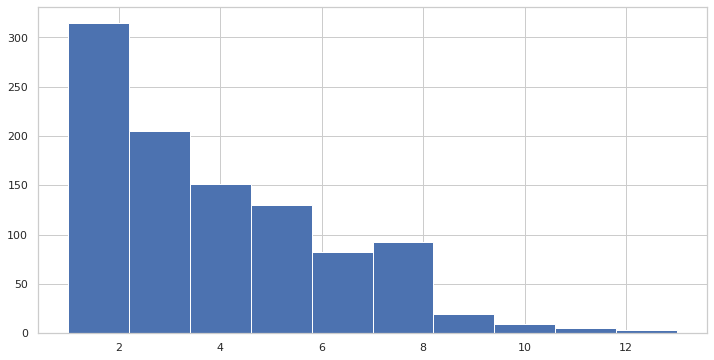

In [18]:
num_cnco['size'].hist()

num_cnco - df с кол-вом заказов по пользователя без разбивки на тестовую и контрольную группу. И визуализация распределения. Посмотрим прицельно по группам 0 и 1.

In [19]:
create_not_cancel_orders0=ab_users_data.query('action=="create_order" & order_id not in @cancelled & group==0')
num_cnco0=create_not_cancel_orders0.groupby(create_not_cancel_orders0.user_id, as_index= False ).size()
num_cnco0

,user_id,size
0,964,2
1,968,3
2,969,2
3,972,1
4,975,2
...,...,...
507,1971,3
508,1972,2
509,1973,4
510,1974,3


In [20]:
create_not_cancel_orders1=ab_users_data.query('action=="create_order" & order_id not in @cancelled & group==1')
num_cnco1=create_not_cancel_orders1.groupby(create_not_cancel_orders1.user_id, as_index= False ).size()
num_cnco1

,user_id,size
0,965,9
1,967,5
2,970,2
3,971,5
4,973,3
...,...,...
496,1976,5
497,1977,4
498,1978,6
499,1979,5


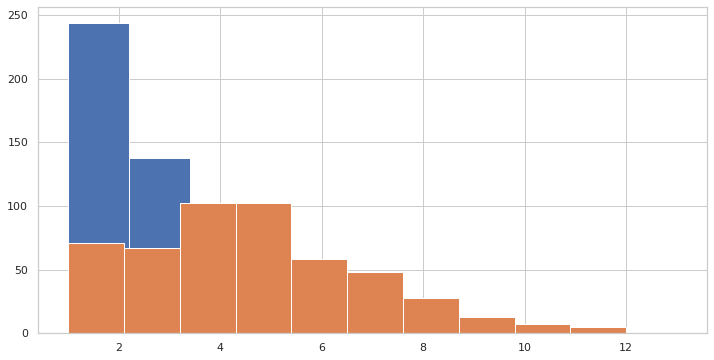

In [21]:
num_cnco0['size'].hist()
num_cnco1['size'].hist()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


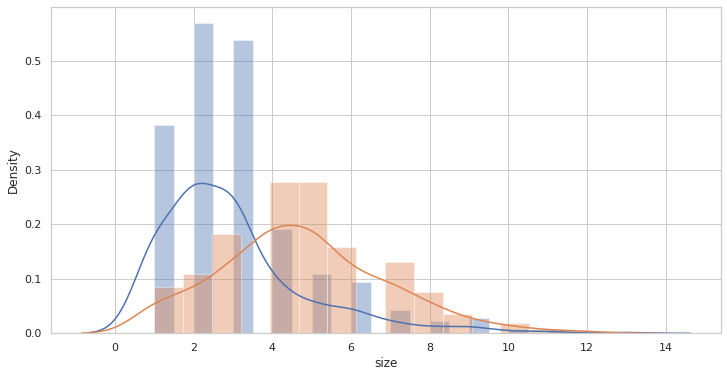

In [22]:
sns.distplot(num_cnco0['size'])
sns.distplot(num_cnco1['size'])

Гистограммы демонстрируют нам, что в контрольной групе (0) чаще всего делают от 1-3 заказов и редко возвращаются за повторными покупками. А вот в тестовой группе (1) кол-во заказов одного пользователя возрастает до 4-6, т.е. более часто возвращаются за повторными покупками.
Распределение кол-ва заказов в 0 группе, скорее, не нормально, в 1 группе больше похоже на нормальное. Проверим это с помощью тестов, предварительно посмотрев на описательные статистики кол-ва заказов.

In [23]:
num_cnco0['size'].describe()

count    512.000000
mean       2.982422
std        1.886631
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       13.000000
Name: size, dtype: float64

In [24]:
num_cnco1['size'].describe()

count    501.000000
mean       4.754491
std        2.138599
min        1.000000
25%        3.000000
50%        5.000000
75%        6.000000
max       12.000000
Name: size, dtype: float64

In [25]:
print(ss.normaltest(num_cnco0['size']))
print(ss.normaltest(num_cnco1['size']))

NormaltestResult(statistic=178.2666269087672, pvalue=1.949367912093664e-39)
NormaltestResult(statistic=17.210719490871693, pvalue=0.0001831216731538631)


H0 (данные распределены нормально) отклоняем,  p<0.05
Распределения не нормальные, попробуем их преобразовать с помощью логарифмирования

In [26]:
print(ss.normaltest(np.log(num_cnco0['size'])))
print(ss.normaltest(np.log(num_cnco1['size'])))

NormaltestResult(statistic=7.232996240382989, pvalue=0.026876630618679398)
NormaltestResult(statistic=71.25566542703895, pvalue=3.365339247085711e-16)


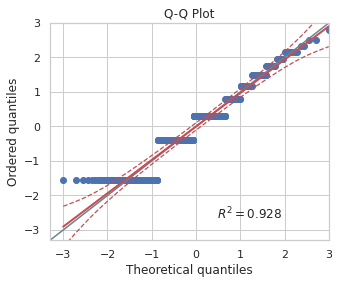

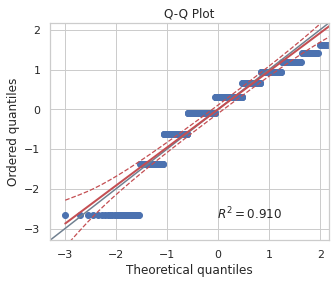

In [27]:
pg.qqplot(np.log(num_cnco0['size']))
pg.qqplot(np.log(num_cnco1['size']))

Но преобразование данных не слишком помогло, и p все еще <0,05 и значит H0 о том, что данные распределены нормально, мы отклоняем. Проверим еще являются ли дисперсии внутри групп примерно одинаковыми.

In [28]:
ss.levene(num_cnco0['size'], num_cnco1['size'])

LeveneResult(statistic=17.19594234323374, pvalue=3.654438888775981e-05)

p<0,05 => дисперсии внутри групп различаются. Условия для t-теста не удовлетворяются, поэтому для проверки 2 выборок между собой в данном случае используем тест Манна-Уитни.
H0 - значимых различий в средних значениях выборок нет,
H1 - различия есть.

In [29]:
ss.mannwhitneyu (num_cnco0['size'], num_cnco1['size'])

MannwhitneyuResult(statistic=62993.5, pvalue=1.2199751971495041e-45)

p<0.05, и это значит, что мы обнаружили статистически значимые различия в средних значениях кол-ва заказов на пользователя в контрольной и тестовых группах. И это позволяет нам сделать предположение, что наблюдаемый эффект - результат эксперимента, а не случайность, и при внедрении новой системы рекомендаций среднее кол-во заказов на пользователя увеличится до ~4-6 единиц.

Тест Манна-Уитни сложен в интерпретации поскольку сравнивает средние ранги между группами, попробуем все же применить t-тест, несмотря на ненормальность распределений и разности дисперсий внутри групп, но хотя бы объем выборки >30, с указанием аргумента equal_var=False в функции t-теста.

In [30]:
ss.ttest_ind(num_cnco0['size'], num_cnco1['size'], equal_var=False)

Ttest_indResult(statistic=-13.974169980221783, pvalue=1.2374101233656574e-40)

p<0.05, полученные различия статистически значимы, т.е. согласуется с результатами Манна-Уитни.

Таким образом, мы ожидаем, что кол-во заказов при внедрении рекомендательной системы на генеральной совокупности увеличится, и можем предположить в связи с этим, что это повлечет рост выручки и прибыли, соотв-но. Проверим это статистически, исследуя немного другие данные. Нам необходимо знать суммы по заказам, для этого преобразуем df ab_orders в более удобный вид для дальнейшего объединения с другими df, используя методы работы со списками и метод explode.

In [31]:
ab_orders['product_ids']=ab_orders['product_ids'].apply(lambda x: x.strip('{}').split(", "))

In [32]:
ab_orders=ab_orders.explode('product_ids')
ab_orders=ab_orders.rename(columns={'product_ids':'product_id'})
ab_orders['product_id']=ab_orders['product_id'].astype('int')
ab_orders

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19.000000,75
0,1255,2022-08-26 00:00:19.000000,22
0,1255,2022-08-26 00:00:19.000000,53
0,1255,2022-08-26 00:00:19.000000,84
1,1256,2022-08-26 00:02:21.000000,56
...,...,...,...
4121,59487,2022-09-08 23:29:06.000000,9
4121,59487,2022-09-08 23:29:06.000000,62
4121,59487,2022-09-08 23:29:06.000000,77
4122,59533,2022-09-08 23:41:24.000000,17


In [33]:
# объединим df ab_orders и ab_products
df_comb=ab_orders.merge(ab_products, how='left', on='product_id')
df_comb

,order_id,creation_time,product_id,name,price
0,1255,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,1255,2022-08-26 00:00:19.000000,22,сок мультифрукт,120.0
2,1255,2022-08-26 00:00:19.000000,53,мука,78.3
3,1255,2022-08-26 00:00:19.000000,84,мандарины,90.4
4,1256,2022-08-26 00:02:21.000000,56,сосиски,150.0
...,...,...,...,...,...
13821,59487,2022-09-08 23:29:06.000000,9,чай черный листовой,83.5
13822,59487,2022-09-08 23:29:06.000000,62,сок яблочный,120.0
13823,59487,2022-09-08 23:29:06.000000,77,курица,298.4
13824,59533,2022-09-08 23:41:24.000000,17,морс брусничный,190.0


In [34]:
# объединим df df_comb и ab_users_data
df_com_comb=df_comb.merge(ab_users_data, how='left', on='order_id')
df_com_comb

,order_id,creation_time,product_id,name,price,user_id,action,time,date,group
0,1255,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,1255,2022-08-26 00:00:19.000000,22,сок мультифрукт,120.0,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
2,1255,2022-08-26 00:00:19.000000,53,мука,78.3,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
3,1255,2022-08-26 00:00:19.000000,84,мандарины,90.4,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
4,1256,2022-08-26 00:02:21.000000,56,сосиски,150.0,965,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
...,...,...,...,...,...,...,...,...,...,...
14564,59487,2022-09-08 23:29:06.000000,9,чай черный листовой,83.5,1461,create_order,2022-09-08 23:29:06.000000,2022-09-08,0
14565,59487,2022-09-08 23:29:06.000000,62,сок яблочный,120.0,1461,create_order,2022-09-08 23:29:06.000000,2022-09-08,0
14566,59487,2022-09-08 23:29:06.000000,77,курица,298.4,1461,create_order,2022-09-08 23:29:06.000000,2022-09-08,0
14567,59533,2022-09-08 23:41:24.000000,17,морс брусничный,190.0,1376,create_order,2022-09-08 23:41:24.000000,2022-09-08,0


Получаем выборки на созданных и не отмененных заказах в контрольной и тестовой группах путем группировки заказов, суммируя наполнение каждого заказа. Смотрим описательные статистики. Визуализируем распределения суммы заказов в группах.

In [35]:
sum_orders0=df_com_comb.query('action=="create_order" & order_id not in @cancelled & group==0').groupby('order_id', as_index=False).agg({'price':'sum'})
sum_orders0

,order_id,price
0,1255,408.7
1,1257,310.2
2,1261,430.7
3,1262,358.6
4,1265,546.4
...,...,...
1522,59176,410.3
1523,59186,497.1
1524,59464,185.9
1525,59487,501.9


In [36]:
sum_orders0.price.describe()

count    1527.000000
mean      382.092927
std       247.993288
min         2.000000
25%       196.000000
50%       325.900000
75%       516.000000
max      1668.600000
Name: price, dtype: float64

In [37]:
sum_orders1=df_com_comb.query('action=="create_order" & order_id not in @cancelled & group==1').groupby('order_id', as_index=False).agg({'price':'sum'})
sum_orders1

,order_id,price
0,1256,250.5
1,1259,228.0
2,1263,180.3
3,1264,310.3
4,1266,46.0
...,...,...
2377,59220,264.2
2378,59250,150.3
2379,59390,620.8
2380,59422,241.2


In [38]:
sum_orders1.price.describe()

count    2382.000000
mean      368.861629
std       246.499077
min         1.000000
25%       190.075000
50%       307.350000
75%       500.950000
max      1835.000000
Name: price, dtype: float64

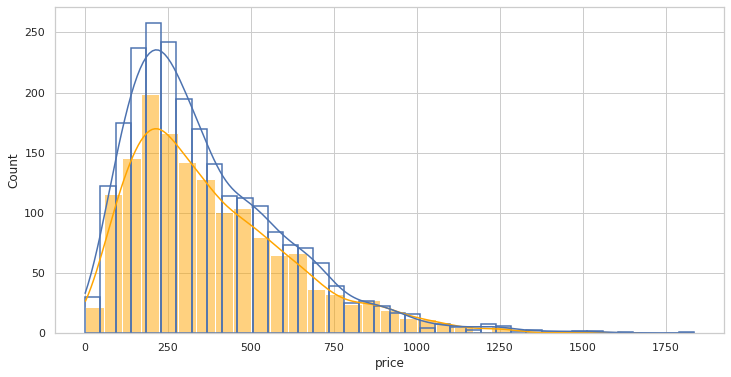

In [39]:
sns.histplot(sum_orders0['price'], kde=True, color='orange')
sns.histplot(sum_orders1['price'], kde=True, fill=False)

Гистограммы суммы заказов по группам очень похожи по виду распределения, распределены значения, скорее, не нормально. Наблюдается разница в кол-ве заказов в группах, что мы смогли подтвердить прошлым исследованием. А вот есть ли ощутимые изменения в средних суммах заказов?

Сравниваются 2 группы, данные количественные. Должен применяться t-тест для проверки гипотез:
H0 - различий в средних значениях между суммами заказов двух выборок нет,
H1 - различия есть.

Проверим на нормальность наши данные.

In [40]:
print(ss.normaltest(sum_orders0['price']))
print(ss.normaltest(sum_orders0['price']))

NormaltestResult(statistic=276.0397772146938, pvalue=1.1447851440676955e-60)
NormaltestResult(statistic=276.0397772146938, pvalue=1.1447851440676955e-60)


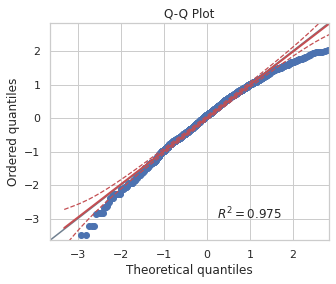

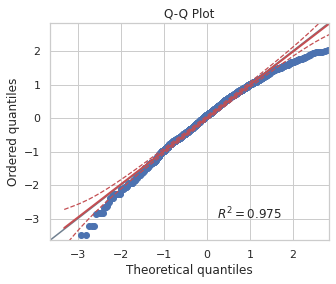

In [41]:
pg.qqplot(np.log(sum_orders0['price']))
pg.qqplot(np.log(sum_orders0['price']))

In [42]:
# p<0.05 => проверка на нормальность не пройдена. Посмотрим что с гомогенностью дисперсии в группах.
ss.levene(sum_orders0['price'], sum_orders1['price'])

LeveneResult(statistic=1.0117862321327593, pvalue=0.31453758452176295)

p>0.05 => дисперсии внутри групп примерно одинаковы. Количество наблюдений в выборках у нас сильно больше 30 и, несмотря на отличие распределений от нормального, попробуем всё же применить t-тест, т.к. иногда фактором "нормальности" можно пренебречь при соблюдении других условий и указанием параметра equal-var.

In [43]:
ss.ttest_ind(sum_orders0['price'],sum_orders1['price'])

Ttest_indResult(statistic=1.6334875192269402, pvalue=0.10244707728234669)

In [44]:
ss.ttest_ind(sum_orders0['price'],sum_orders1['price'], equal_var=False)

Ttest_indResult(statistic=1.6313291830498775, pvalue=0.10291811015193121)

p>0.05, и это значит, что оснований не достаточно, чтобы отклонить H0. Т.е. различий в средних значениях между суммами заказов двух выборок нет.

Попробуем применить тест Манна-Уитни, но и он нам показывает p>0.05.

In [45]:
ss.mannwhitneyu(sum_orders0['price'],sum_orders1['price'])

MannwhitneyuResult(statistic=1879868.0, pvalue=0.07539952478041778)

На текущий момент знаем, что при внедрении рекомендательной системы мы можем рассчитывать на увеличение среднего кол-ва заказов на пользователя, но при этом изменений в средних значениях сумм заказов мы не ожидаем.
Проверим еще одну метрику - ср.чек. Ниже df со значениями ср. чеков на пользователя. Далее смотрим описательные статистики и распределения:

In [46]:
df_check=df_com_comb.query('action=="create_order" & order_id not in @cancelled').groupby(['user_id', 'group'], as_index=False).agg({'price':['sum'], 'order_id':['nunique']})
df_check.columns=df_check.columns.droplevel(1)
df_check=df_check.rename(columns={'price':'sum_of_orders', 'order_id':'num_of_orders'})
df_check['mean_check']=df_check['sum_of_orders']/df_check['num_of_orders']
df_check

,user_id,group,sum_of_orders,num_of_orders,mean_check
0,964,0,718.9,2,359.450000
1,965,1,4155.5,9,461.722222
2,967,1,1137.4,5,227.480000
3,968,0,1590.7,3,530.233333
4,969,0,681.9,2,340.950000
...,...,...,...,...,...
1008,1976,1,2001.9,5,400.380000
1009,1977,1,781.2,4,195.300000
1010,1978,1,2276.3,6,379.383333
1011,1979,1,1907.1,5,381.420000


In [47]:
df_check.query('group==0').mean_check.describe()

count     512.000000
mean      386.039053
std       172.036518
min        25.000000
25%       268.881818
50%       362.666667
75%       475.883333
max      1240.800000
Name: mean_check, dtype: float64

In [48]:
df_check.query('group==1').mean_check.describe()

count    501.000000
mean     371.203622
std      131.242699
min       83.500000
25%      286.066667
50%      355.925000
75%      434.437500
max      937.400000
Name: mean_check, dtype: float64

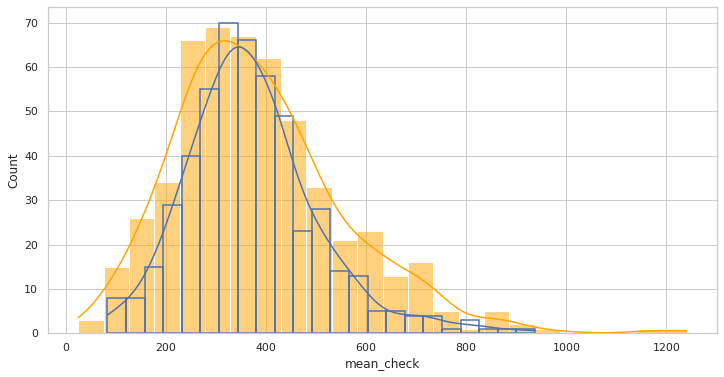

In [49]:
sns.histplot(df_check.query('group==0').mean_check, kde=True, color='orange')
sns.histplot(df_check.query('group==1').mean_check, kde=True, fill=False)

In [50]:
pg.normality(data=df_check, dv="mean_check", group="group", method="normaltest")

,W,pval,normal
0,82.503208,1.215223e-18,False
1,71.621174,2.803236e-16,False


In [51]:
ss.levene(df_check.query('group==0').mean_check, df_check.query('group==1').mean_check)

LeveneResult(statistic=26.849002499033574, pvalue=2.6550924048745973e-07)

In [52]:
print(ss.normaltest(np.log(df_check.query('group==0').mean_check)))
print(ss.normaltest(np.log(df_check.query('group==1').mean_check)))

NormaltestResult(statistic=77.72953173684436, pvalue=1.322046232532663e-17)
NormaltestResult(statistic=53.94152434214554, pvalue=1.9352934037958913e-12)


Тест на нормальность не выполнен, внутригрупповые дисперсии различаются. Пробуем прологарифмировать данные, но даже в результате преобразований они значимо отличаются от нормальных. В данном случае также могли бы применить t-тест с указанием аргумента equal_var, но попробуем bootstrap.

In [53]:
ci = pg.compute_bootci(df_check.query('group==0').mean_check, func='mean')
print(ci)

[372.8  401.65]


In [54]:
ci = pg.compute_bootci(df_check.query('group==1').mean_check, func='mean')
print(ci)

[359.98 382.56]


Полученные 95% доверительные интервалы в контрольной и тестовой группах перекрываются,  и это означает, что статистически значимого отличия в полученных оценках параметра нет. H0 о том, что различий в выборках в средних значениях ср.чека нет, не может быть отклонена.

In [55]:
# Здесь опробоан альтернативнй метод расчета доверительного интервала для разницы между средними значениями ср. чека.
df_check0 = df_check[df_check.group == 0]
df_check1 = df_check[df_check.group == 1]
mean_diff = []

for i in range(1000):
    sample_data_0 = df_check0.sample(frac=1, replace=True)
    sample_mean_0 = sample_data_0.mean_check.mean()
    
    
    sample_data_1 = df_check1.sample(frac=1, replace=True)
    sample_mean_1 = sample_data_1.mean_check.mean()
    
    sample_mean_diff = sample_mean_0 - sample_mean_1
    mean_diff.append(sample_mean_diff)

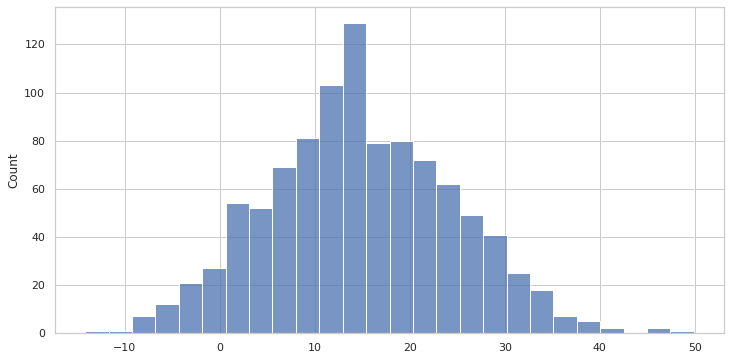

In [56]:
# визуализация распределения разницы средних
sns.histplot(mean_diff)

In [57]:
pd.Series(mean_diff).quantile(0.975)

33.88373923272359

In [58]:
pd.Series(mean_diff).quantile(0.025)

-3.8244800217535126

Полученный доверительный интервал включает в себя 0, и это не позволяет отклонить нам H0.

In [59]:
ss.ttest_ind(df_check.query('group==0').mean_check, df_check.query('group==1').mean_check, equal_var=False)

Ttest_indResult(statistic=1.5451367735756034, pvalue=0.12264464021798561)

Запустив t-тест "для себя" также обнаружили p>0.05, оснований недостаточно, чтобы отклонить H0. Все проведенные тесты в отношении средних значений среднего чека не противоречат друг другу, и привели нас к одному выводу - различий по этому показателю в контрольной и тестовой группах нет.
Таким образом, мы уже знаем, что различий в соотношении отмененных и не отмененных заказов в тестовой и контрольной группах нет, но при этом, есть стат-ки значимые различия по метрике "кол-во заказов на пользователя" - оно возросло в тестовой группе. Далее, исследования метрик по суммам заказов и ср.чека на покупателя не показали нам значимых различий. Так как средний чек не изменился, а число заказов выросло, то логично сделать предположение о росте выручки. Проверим нашу гипотезу стат-ки с помощью метрики "средняя выручка на платящего пользователя", которая также уже посчитана в df_check - sum_of_orders. Описательные статистики и распределения ниже:

In [83]:
df_check.query('group==0').sum_of_orders.describe()

count     512.000000
mean     1139.562305
std       809.808924
min        25.000000
25%       571.700000
50%       955.700000
75%      1498.600000
max      5589.800000
Name: sum_of_orders, dtype: float64

In [84]:
df_check.query('group==1').sum_of_orders.describe()

count     501.000000
mean     1753.749301
std       928.760937
min        83.500000
25%      1065.800000
50%      1630.100000
75%      2376.000000
max      4576.200000
Name: sum_of_orders, dtype: float64

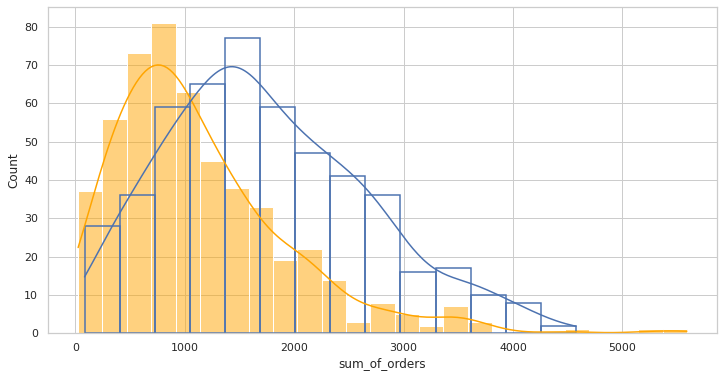

In [85]:
sns.histplot(df_check.query('group==0').sum_of_orders, kde=True, color='orange')
sns.histplot(df_check.query('group==1').sum_of_orders, kde=True, fill=False)

На первый взгляд, изменения ср выручки в группах значимы. Проверим это статистически: H0-различий относительно метрики ср выручки нет в группах,  H1- есть стат-ки значимые различия.
Тест на нормальность сообщает о ненормальном распределении нашего признака, но мы помним, что у нас достаточно наблюдений и поправка equal_var=False в t-тесте позволяет нам пренебречь условием нормальности для t-теста. Тест Левена на равенство дисперсий между двумя группами показывает p<0.05 => дисперсия среди групп не одинакова. Но руководствуясь результатами прошлых исследований, используем t-тест,  т.к. на этих данных мы уже получали с помощью него вполне адекватные заключения.

In [86]:
pg.normality(data=df_check, dv="sum_of_orders", group="group", method="normaltest")

,W,pval,normal
0,165.141459,1.380345e-36,False
1,21.243034,2.438562e-05,False


In [87]:
ss.levene(df_check.query('group==0').sum_of_orders, df_check.query('group==1').sum_of_orders)

LeveneResult(statistic=18.46665773943807, pvalue=1.896012459520485e-05)

In [88]:
ss.ttest_ind(df_check.query('group==0').sum_of_orders, df_check.query('group==1').sum_of_orders, equal_var=False)

Ttest_indResult(statistic=-11.208629753614106, pvalue=1.5721664294812436e-27)

p<0.05. H0 отклоняется и принимается альтернативная гипотеза о получении стат-ки значимых различий в группах касательно метрики ср.выручки.
Также, проверив нашу гипотезу методом bootstrap, получили 95% доверительные интервалы в контрольной и тестовой группах, которые не перекрываются,  и это означает, что статистически значимое отличие в полученных оценках параметра есть.

In [89]:
ci = pg.compute_bootci(df_check.query('group==0').sum_of_orders, func='mean')
print(ci)

[1069.38 1210.85]


In [90]:
ci = pg.compute_bootci(df_check.query('group==1').sum_of_orders, func='mean')
print(ci)

[1670.71 1833.53]


Полученные стат-ки значимые результаты по кол-ву заказов и ср. выручке на пользователя в тестовой группе говорят в пользу включения новой системы рекомендаций на всех пользователей.